# cityB SVR
ver10:シンプルSVRを作成した。
ver20:ここで、越智さんがしてた学習データの欠損埋めを行ってからSVRを適用してみる。  
ver30:クラスタリングのタイプ別をいれてみる
ver40:移動系の特徴量もいれてみる

#### 設定

In [62]:
# BLEUのインストール
!git clone https://github.com/yahoojapan/geobleu.git
!pip install geobleu/

fatal: destination path 'geobleu' already exists and is not an empty directory.
Processing ./geobleu
  Preparing metadata (setup.py) ... done
  Created wheel for geobleu: filename=geobleu-0.3-py3-none-any.whl size=5037 sha256=38b14ea1d456a8f641b3ae37c6f194864ea7ba80ecc8b4f515e19a3b8711f017
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkkgko2n/wheels/15/98/c8/330b8225e74188a134268a5ac7b536896fe9cc4650bc728bc9
Successfully built geobleu
  Attempting uninstall: geobleu
    Found existing installation: geobleu 0.3
    Uninstalling geobleu-0.3:
      Successfully uninstalled geobleu-0.3


In [63]:
import pandas as pd
import numpy as np
import geobleu
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [64]:
INPUT_PATH = "../../s3storage/01_public/humob-challenge-2024/input/cityB_challengedata.csv.gz"
# INPUT_PATH = "/kaggle/input/humob2024/cityB_challengedata.csv/hiroshima_challengedata.csv"

#### データ読み込み

In [65]:
df_city_b = pd.read_csv(INPUT_PATH)
df_city_b.head(3)

,uid,d,t,x,y
0,0,0,20,80,99
1,0,0,21,81,97
2,0,0,25,83,102


#### ユーザーを絞り込み、d=60前後で訓練データと正解データに分割

In [152]:
# uidが20000~21999のデータを検証に利用
df_city_b_valid = (
    df_city_b
    .loc[df_city_b["uid"].between(20000, 21999)]
    # .loc[df_city_b["uid"].between(20000, 20100)]

)
df_city_b_valid.head(3)

,uid,d,t,x,y
20253615,20000,0,0,79,89
20253616,20000,0,2,79,89
20253617,20000,0,5,79,89


In [153]:
# dが60前後でデータを分割
df_city_b_train = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] < 60]
)

df_city_b_answer = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] >= 60]
)

In [154]:
def get_full_df(df, d_range, t_range):
    """
    input: uid, d, t, x, yのdf
    output: 全uidでd×tを揃えたdfを作成。x, yが欠損値の場合はnull。
    """
    # 全てのd, tの範囲のデータフレームを作成
    full_range_d = pd.DataFrame({'d': range(0, d_range)})
    full_range_t = pd.DataFrame({'t': range(0, t_range)})

    # uidのユニークな値を取得し、クロス結合を行う
    full_range_uid = pd.DataFrame({'uid': df['uid'].unique()})

    # クロス結合を行う（全てのuid, d, tの組み合わせ）
    full_range = (full_range_uid.assign(key=1)
                  .merge(full_range_d.assign(key=1), on='key')
                  .merge(full_range_t.assign(key=1), on='key')
                  .drop('key', axis=1)
                 )

    # x, yの値を付与し、欠損値はnullとする
    df_train_full = (full_range
                     .merge(df, on=['uid', 'd', 't'], how='left')
                     .sort_values(by=['uid', 'd', 't'])
                    )

    return df_train_full

In [155]:
def interpolate_missing_values(df,N):
    """
    input: uid, d, t, x, yのdf、uidにつきd×tは60×48、x, y欠損値はnull
    output: 3時間未満の連続するx, y欠損を直近の前後のx, y値を用いて線形補完したdf
    """
    df_fill = df.fillna(-1).copy()  # 欠損値を一時的に -1 に変換
    skip_list = []
    interpolate_num = 0
    
    for i in range(len(df_fill)):
#     for i in range(20):
        prev_valid = None
        next_valid = None
        time_diff = None
        
        # skip_listのインデックスは飛ばす
        if i in skip_list:
            continue
        
        # x, yが欠損の場合
        if df_fill.loc[i, "x"] == -1 and df_fill.loc[i, "y"] == -1:
            # 前の有効なデータを探す
            if prev_valid is None and i != 0:
                if df_fill.loc[i - 1, "x"] != -1:
                    prev_valid = df_fill.loc[i - 1]  # 前のデータが有効な場合
            
            # 次の有効なデータを探す
            if next_valid is None:
                for j in range(i + 1, len(df)):
                    if df_fill.loc[j, "x"] != -1 and df_fill.loc[j, "y"] != -1:
                        next_valid = df_fill.loc[j]
                        break

            # 前後の有効データが見つかった場合
            if prev_valid is not None and next_valid is not None:
#                 print(i, prev_valid, next_valid)
                time_diff = int(next_valid["t"] - prev_valid["t"])
                
                # 3時間未満の欠損なら線形補完
                if (time_diff != 0) and (time_diff < N*2):
                    x_diff = next_valid["x"] - prev_valid["x"]
                    y_diff = next_valid["y"] - prev_valid["y"]
                    
                    for j in range(i, i + time_diff -1):
                        time_from_prev = df.loc[j, "t"] - prev_valid["t"]
                        # 欠損値を線形補完
                        df_fill.loc[j, "x"] = prev_valid["x"] + (x_diff / time_diff) * time_from_prev
                        df_fill.loc[j, "y"] = prev_valid["y"] + (y_diff / time_diff) * time_from_prev
                    
                    # 補完済みのインデックスをリストに追加
                    skip_list = [j for j in range(i, i + time_diff - 1)]
                    interpolate_num += len(skip_list)
#                     print(skip_list)
#                     print(df_fill.iloc[i-1:i+time_diff+3,:])
                    
#                 else:
#                     print(f"Skipping interpolation for index {i}.")
    print(f"補完数：{interpolate_num}")
    # 欠損値が補完されたdfを返す
    df_fill = df_fill[df_fill["x"]!=-1]
    df_fill["x"] =df_fill["x"].astype(int)
    df_fill["y"] =df_fill["y"].astype(int)

    
    return df_fill

In [156]:
## あとで学習データの補完もしてみる
df_city_b_train_full = get_full_df(df_city_b_train, d_range=60, t_range=48)
df_city_b_train_full

,uid,d,t,x,y
0,20000,0,0,79.0,89.0
1,20000,0,1,NaN,NaN
2,20000,0,2,79.0,89.0
3,20000,0,3,NaN,NaN
4,20000,0,4,NaN,NaN
...,...,...,...,...,...
5759995,21999,59,43,NaN,NaN
5759996,21999,59,44,NaN,NaN
5759997,21999,59,45,NaN,NaN
5759998,21999,59,46,NaN,NaN


In [157]:
INTEROILATE_N = 8
df_city_b_train_ip = interpolate_missing_values(df_city_b_train_full,INTEROILATE_N)

補完数：1269880


In [158]:
df_city_b_train_ip_bk = df_city_b_train_ip

In [159]:
len(df_city_b_train_ip)

2649706

### 特徴量の作成

In [160]:
def attach_feature_data_and_time(df):
    df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
    df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
    df["date_ant_time_alpha_t"] = np.sin(2 * np.pi/24 * df["t"])
    df["date_ant_time_beta_t"] = np.cos(2 * np.pi/24 * df["t"])
    return df

In [161]:
def attach_feature_activity_time(df):
    # act の定義: 18 ≤ t < 23 または 33 ≤ t < 38
    df['act'] = np.where(((df['t'] >= 18) & (df['t'] < 23)) | ((df['t'] >= 33) & (df['t'] < 38)), 1, 0)

    # high_act の定義: 23 ≤ t < 33
    df['high_act'] = np.where((df['t'] >= 23) & (df['t'] < 33), 1, 0)

    # rest の定義: 13 ≤ t < 18 または 38 ≤ t < 44
    df['rest'] = np.where(((df['t'] >= 13) & (df['t'] < 18)) | ((df['t'] >= 38) & (df['t'] < 44)), 1, 0)

    # deep_rest の定義: 0 ≤ t < 13 または 44 ≤ t < 48
    df['deep_rest'] = np.where(((df['t'] >= 0) & (df['t'] < 13)) | ((df['t'] >= 44) & (df['t'] < 48)), 1, 0)

    return df

In [162]:
def attach_feature_day_of_week(df):
    # d = 0が2020/1/5に対応
    df["date"]  = pd.to_datetime("2020-01-05") + pd.to_timedelta(df["d"],unit="D")
    
    # 曜日 0:Mon,... 5:Sat,6:Sun
    df["dow"] = df["date"].dt.weekday
    
    return df.drop(columns = ["date"])

In [163]:
def attach_feature_weekday_holiday(df):
    df['weekdays'] = df['dow'].apply(lambda x: 0 if x in [5, 6] else 1)

    return df

In [164]:
def attach_feature_am_pm(df):
    # AM フラグを設定: 0 ≤ t < 25 は 1、それ以外は 0
    df['AM'] = np.where((df['t'] >= 0) & (df['t'] < 25), 1, 0)
    
    # # PM フラグを設定: AM が 0 の場合は PM は 1、AM が 1 の場合は PM は 0
    # df['PM'] = np.where(df['AM'] == 1, 0, 1)
    return df

In [165]:
# ユークリッド距離を計算する関数
def calc_euclidean_distance(row1, row2):
    return np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)

# 移動角度を計算する関数
def calc_angle(row1, row2):
    delta_x = row2['x'] - row1['x']
    delta_y = row2['y'] - row1['y']
    angle = np.arctan2(delta_y, delta_x)
    return np.degrees(angle) % 360

# 各特徴量ごとに移動系の特徴量を計算して付与する関数
def attach_movement_features_by_columns(df, group_columns):
    for col in group_columns:
        print(f"Processing for {col}...")  # 処理の進捗を表示
        
        result_list = []

        # 各特徴量でグループ化して処理を実行（進捗をtqdmで表示）
        for values, group in tqdm(df.groupby(['uid', col]), desc=f"Processing {col}"):
            group = group.sort_values(by=['d', 't'])  # 時間ベースでソート

            euclidean_distances = []
            angles = []

            # 移動距離と角度を計算
            for i in range(1, len(group)):
                dist_euc = calc_euclidean_distance(group.iloc[i-1], group.iloc[i])
                angle = calc_angle(group.iloc[i-1], group.iloc[i])
                euclidean_distances.append(dist_euc)
                angles.append(angle)

            move_count = len(euclidean_distances)

            # 移動距離の平均、標準偏差、移動角度の平均を計算
            if move_count > 0:
                avg_euclidean_distance = np.mean(euclidean_distances)
                std_euclidean_distance = np.std(euclidean_distances)
                avg_angle = np.mean(angles)
            else:
                avg_euclidean_distance = 0
                std_euclidean_distance = 0
                avg_angle = 0

            # グループ化された値ごとの結果を保存
            result_dict = {
                'uid': values[0],
                col: values[1],
                f'move_count_{col}': move_count,
                f'avg_euclidean_distance_{col}': avg_euclidean_distance,
                f'std_euclidean_distance_{col}': std_euclidean_distance,
                f'avg_angle_{col}': avg_angle
            }
            result_list.append(result_dict)

        # 結果をデータフレームに変換してマージ
        result_df = pd.DataFrame(result_list)
        df = pd.merge(df, result_df, on=['uid', col], how='left')
    
    return df

In [166]:
def attach_features_about_date_and_time(df):
    df = attach_feature_data_and_time(df)
    df = attach_feature_activity_time(df)
    df = attach_feature_day_of_week(df)
    df = attach_feature_weekday_holiday(df)
    df = attach_feature_am_pm(df) 

    return df

In [167]:
# 学習データに特徴量付与
df_city_b_train_ip = attach_features_about_date_and_time(df_city_b_train_ip_bk)

In [168]:
# 特徴量リスト（uidを追加）
group_columns = ['act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM']
# group_columns = ['AM']


# 実際に特徴量を付与
df_city_b_train_ip = attach_movement_features_by_columns(df_city_b_train_ip, group_columns)


Processing for act...


Processing act: 100%|██████████| 3999/3999 [05:52<00:00, 11.35it/s]


Processing for high_act...


Processing high_act: 100%|██████████| 3998/3998 [06:44<00:00,  9.89it/s]


Processing for rest...


Processing rest: 100%|██████████| 4000/4000 [07:47<00:00,  8.56it/s]


Processing for deep_rest...


Processing deep_rest: 100%|██████████| 3968/3968 [07:07<00:00,  9.28it/s]


Processing for dow...


Processing dow: 100%|██████████| 13957/13957 [06:59<00:00, 33.28it/s]


Processing for weekdays...


Processing weekdays: 100%|██████████| 3999/3999 [09:10<00:00,  7.27it/s]


Processing for AM...


Processing AM: 100%|██████████| 3999/3999 [09:43<00:00,  6.86it/s]


In [169]:
df_city_b_train_ip_bk2 = df_city_b_train_ip

In [170]:
df_city_b_train_ip.columns

Index(['uid', 'd', 't', 'x', 'y', 'date_ant_time_alpha_d',
       'date_ant_time_beta_d', 'date_ant_time_alpha_t', 'date_ant_time_beta_t',
       'act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM',
       'move_count_act', 'avg_euclidean_distance_act',
       'std_euclidean_distance_act', 'avg_angle_act', 'move_count_high_act',
       'avg_euclidean_distance_high_act', 'std_euclidean_distance_high_act',
       'avg_angle_high_act', 'move_count_rest', 'avg_euclidean_distance_rest',
       'std_euclidean_distance_rest', 'avg_angle_rest', 'move_count_deep_rest',
       'avg_euclidean_distance_deep_rest', 'std_euclidean_distance_deep_rest',
       'avg_angle_deep_rest', 'move_count_dow', 'avg_euclidean_distance_dow',
       'std_euclidean_distance_dow', 'avg_angle_dow', 'move_count_weekdays',
       'avg_euclidean_distance_weekdays', 'std_euclidean_distance_weekdays',
       'avg_angle_weekdays', 'move_count_AM', 'avg_euclidean_distance_AM',
       'std_euclidean_distance_AM',

In [171]:
df_city_b_train_ip[(df_city_b_train_ip["uid"] == 20000)&(df_city_b_train_ip["weekdays"] == 0)].head(5)

,uid,d,t,x,y,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,...,std_euclidean_distance_dow,avg_angle_dow,move_count_weekdays,avg_euclidean_distance_weekdays,std_euclidean_distance_weekdays,avg_angle_weekdays,move_count_AM,avg_euclidean_distance_AM,std_euclidean_distance_AM,avg_angle_AM
0,20000,0,0,79,89,0.0,1.0,0.000000,1.000000,0,...,5.013955,54.27653,574,0.980252,3.795846,49.903465,1054,1.069696,4.957501,55.754216
1,20000,0,1,79,89,0.0,1.0,0.258819,0.965926,0,...,5.013955,54.27653,574,0.980252,3.795846,49.903465,1054,1.069696,4.957501,55.754216
2,20000,0,2,79,89,0.0,1.0,0.500000,0.866025,0,...,5.013955,54.27653,574,0.980252,3.795846,49.903465,1054,1.069696,4.957501,55.754216
3,20000,0,3,79,89,0.0,1.0,0.707107,0.707107,0,...,5.013955,54.27653,574,0.980252,3.795846,49.903465,1054,1.069696,4.957501,55.754216
4,20000,0,4,79,89,0.0,1.0,0.866025,0.500000,0,...,5.013955,54.27653,574,0.980252,3.795846,49.903465,1054,1.069696,4.957501,55.754216


In [172]:
df_city_b_train_ip[(df_city_b_train_ip["uid"] == 20000)&(df_city_b_train_ip["weekdays"] == 1)].head(5)

,uid,d,t,x,y,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,...,std_euclidean_distance_dow,avg_angle_dow,move_count_weekdays,avg_euclidean_distance_weekdays,std_euclidean_distance_weekdays,avg_angle_weekdays,move_count_AM,avg_euclidean_distance_AM,std_euclidean_distance_AM,avg_angle_AM
47,20000,1,0,80,89,0.781831,0.62349,0.000000,1.000000,0,...,1.179804,38.437676,1578,0.739032,3.346881,49.511782,1054,1.069696,4.957501,55.754216
48,20000,1,1,79,89,0.781831,0.62349,0.258819,0.965926,0,...,1.179804,38.437676,1578,0.739032,3.346881,49.511782,1054,1.069696,4.957501,55.754216
49,20000,1,2,79,89,0.781831,0.62349,0.500000,0.866025,0,...,1.179804,38.437676,1578,0.739032,3.346881,49.511782,1054,1.069696,4.957501,55.754216
50,20000,1,3,79,89,0.781831,0.62349,0.707107,0.707107,0,...,1.179804,38.437676,1578,0.739032,3.346881,49.511782,1054,1.069696,4.957501,55.754216
51,20000,1,4,79,89,0.781831,0.62349,0.866025,0.500000,0,...,1.179804,38.437676,1578,0.739032,3.346881,49.511782,1054,1.069696,4.957501,55.754216


### クラスタリング

In [173]:
uid_features = (
    df_city_b_train_ip
    .drop(columns=["d","t","x","y"])
    .groupby("uid").agg({
        'date_ant_time_alpha_t': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'date_ant_time_beta_t': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'act': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'high_act': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'rest': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'deep_rest': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'dow': [lambda x: x.mode()[0]],  # 最頻値
        'weekdays': [lambda x: x.mode()[0]],  # 最頻値
        'AM': [lambda x: x.mode()[0]],  # 最頻値
    })
)
uid_features.columns = ['_'.join(col).replace('<lambda_0>', 'mode').replace('<lambda>', 'mode') for col in uid_features.columns]
uid_features.reset_index()

,uid,date_ant_time_alpha_t_sum,date_ant_time_alpha_t_mode,date_ant_time_beta_t_sum,date_ant_time_beta_t_mode,act_sum,act_mode,high_act_sum,high_act_mode,rest_sum,rest_mode,deep_rest_sum,deep_rest_mode,dow_mode,weekdays_mode,AM_mode
0,20000,-124.585671,-1.000000e+00,-170.132672,-1.000000,541,0,521,0,577,0,515,0,1,1,0
1,20001,14.381084,1.000000e+00,-74.421445,-1.000000,473,0,477,0,277,0,126,0,6,1,0
2,20002,-95.083614,-1.000000e+00,-12.493896,-0.965926,430,0,454,0,306,0,88,0,2,1,0
3,20003,19.665818,1.000000e+00,-52.611625,-1.000000,402,0,496,0,345,0,319,0,3,1,1
4,20004,-2.981375,5.000000e-01,-20.834115,-1.000000,475,0,503,0,247,0,38,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,21995,-10.238816,-1.000000e+00,-91.339951,-1.000000,426,0,407,0,304,0,205,0,0,1,0
1996,21996,-69.764466,-1.000000e+00,-143.118841,-0.965926,397,0,356,0,472,0,529,0,6,1,1
1997,21997,-43.023761,3.673940e-16,-151.418924,-1.000000,317,0,266,0,237,0,79,0,6,1,0
1998,21998,21.501744,2.588190e-01,-124.700845,-0.965926,499,0,506,0,281,0,36,0,2,1,0


In [174]:
feature_list = [
    'date_ant_time_alpha_t_sum',
    'date_ant_time_alpha_t_mode',
    'date_ant_time_beta_t_sum',
    'date_ant_time_beta_t_mode',
    'act_sum',
    'act_mode',
    'high_act_sum',
    'high_act_mode',
    'rest_sum',
    'rest_mode',
    'deep_rest_sum',
    'deep_rest_mode',
    'dow_mode',
    'weekdays_mode',
    'AM_mode',
]

In [175]:
kmeans = KMeans(n_clusters=4, random_state=119)
uid_features['cluster'] = kmeans.fit_predict(
    uid_features[feature_list]
)
uid_features["cluster"].value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    617
3    607
2    428
1    348
Name: count, dtype: int64

In [176]:
score = silhouette_score(uid_features[feature_list], uid_features["cluster"])
score

0.28104909518972065

In [177]:
df_city_b_train_ip = (
    pd.merge(
        df_city_b_train_ip,
        uid_features,
        on = ["uid"],
        how="left"
    )
).drop(columns=feature_list)

In [178]:
df_city_b_train_ip[df_city_b_train_ip.isnull().any(axis=1)]

,uid,d,t,x,y,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,...,avg_angle_dow,move_count_weekdays,avg_euclidean_distance_weekdays,std_euclidean_distance_weekdays,avg_angle_weekdays,move_count_AM,avg_euclidean_distance_AM,std_euclidean_distance_AM,avg_angle_AM,cluster


### 学習

In [179]:
# ユーザーごと（uidごと）にデータを分けてモデルを作成
# 学習データがあるuidのみに絞り込む <- データが無い人はどうする？
uids = df_city_b_train_ip['uid'].unique()

# 各uidごとにモデルを作成し、結果を格納する辞書
models = {}
future_predictions = []

for uid in tqdm(uids,desc="Processing uids"):
# for uid in range(20000,20010):

    # 該当uidのデータを抽出
    user_data = df_city_b_train_ip[df_city_b_train_ip['uid'] == uid]
    # 学習に必要ないカラムは除去
    user_data_train = user_data.drop(columns=["uid","d","t","x","y"])

    #目的変数の設定
    y_train_x = user_data['x']
    y_train_y = user_data['y']

    # データの標準化
    scaler = StandardScaler()
    user_data_train_scaled = scaler.fit_transform(user_data_train)

    # SVR モデルの作成と学習 (xとyそれぞれのモデル)
    svr_x = SVR(kernel='rbf')
    svr_x.fit(user_data_train_scaled, y_train_x)

    svr_y = SVR(kernel='rbf')
    svr_y.fit(user_data_train_scaled, y_train_y) 

    # モデルの保存
    models[(uid, 'x')] = svr_x
    models[(uid, 'y')] = svr_y

    # 未来の予測
    # 予測期間の設定 (d=60からd=74まで)
    d_range = np.arange(60, 75)  # 60～74のd値
    time_range = np.arange(0, 48)  # t=0～47の範囲 (30分ごと)

    # d と t の組み合わせを生成
    future_dates = pd.DataFrame([(d, t) for d in d_range for t in time_range], columns=['d', 't'])
    
    # dとtだけで決まる特徴量を作成
    future_dates_featured = attach_features_about_date_and_time(future_dates)
    future_dates_featured = future_dates_featured.drop(columns=["d","t"])

     # 未来データに対して特徴量を付与する関数
    def attach_future_movement_features(df, user_data, group_columns):
        for col in group_columns:
            # 特定の値に基づいて特徴量を付与
            for feature in [f'move_count_{col}', f'avg_euclidean_distance_{col}', 
                            f'std_euclidean_distance_{col}', f'avg_angle_{col}']:
                feature_values = user_data.groupby(col)[feature].last().reset_index()

                # 未来データに過去の特徴量を付与
                df = pd.merge(df, feature_values, on=col, how='left')

        return df
        
    group_columns = ['act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM']
    future_dates_featured = attach_future_movement_features(future_dates_featured, user_data,group_columns)


    #ここでclusterを付与
    future_dates_featured['cluster'] = user_data["cluster"].to_list()[0]

    future_dates_featured.fillna(future_dates_featured.mean(), inplace=True)

    # 標準化
    future_df_scaled = scaler.transform(future_dates_featured)

    #学習したモデルで未来予測
    y_pred_x = svr_x.predict(future_df_scaled)
    y_pred_y = svr_y.predict(future_df_scaled)
    
    
    # 予測データを整形
    future_dates['uid'] = uid
    future_dates['x'] = y_pred_x
    future_dates['y'] = y_pred_y
    future_predictions.append(future_dates)


# uidをすべて結合
future_predictions_df = pd.concat(future_predictions, ignore_index=True)
future_predictions_df["x"] = future_predictions_df["x"].round(0)
future_predictions_df["y"] = future_predictions_df["y"].round(0)

Processing uids: 100%|██████████| 2000/2000 [07:10<00:00,  4.64it/s]


In [180]:
### 正解データと予測データの組み合わせ
combined_data = (
    pd.merge(
        df_city_b_answer,
        future_predictions_df.rename(columns = {"x":"x_pred","y":"y_pred"}),
        on = ["uid","d","t"],
        # ここで正解データ基準で結合してよいか？正解データ自体の欠損はどうする？
        how = "left"
    )
)[["uid","d","t","x","y","x_pred","y_pred"]]


In [181]:
list_geobleu_val = []
list_dtw_val = []

for i in tqdm(range(20000, 22000),desc="Processing uids"):
# for i in tqdm(range(20000, 20100),desc="Processing uids"):
    
    # 該当uidのデータを抽出
    df = (
        combined_data
        .loc[combined_data["uid"] == i]
    )

    # 予測値のリスト
    df_pred = df[["d", "t", "x_pred", "y_pred"]]
    list_pred = [tuple(row) for row in df_pred.to_records(index=False)]

    # 正解値のリスト
    df_answer = df[["d", "t", "x", "y"]]
    list_answer = [tuple(row) for row in df_answer.to_records(index=False)]

    # スコア算出
    geobleu_val = geobleu.calc_geobleu(list_pred, list_answer, processes=3)
    list_geobleu_val.append(geobleu_val)
    
    dtw_val = geobleu.calc_dtw(list_pred, list_answer, processes=3)
    list_dtw_val.append(dtw_val)


Processing uids: 100%|██████████| 2000/2000 [29:06<00:00,  1.15it/s]


In [182]:
# v40
print(f"geobleu:{np.mean(list_geobleu_val)}")
print(f"dtw:{np.mean(list_dtw_val)}")

geobleu:0.23166449571662934
dtw:24.50678262422581


In [66]:
# v30の指標
geobleu:0.23144646201037913
dtw:24.75290723926348

geobleu:0.23144646201037913
dtw:24.75290723926348


(array([266., 244., 246., 238., 191., 171., 160., 121., 116.,  72.,  58.,
         44.,  34.,  16.,  13.,   3.,   3.,   0.,   0.,   4.]),
 array([1.90673321e-14, 4.89122651e-02, 9.78245302e-02, 1.46736795e-01,
        1.95649060e-01, 2.44561325e-01, 2.93473590e-01, 3.42385856e-01,
        3.91298121e-01, 4.40210386e-01, 4.89122651e-01, 5.38034916e-01,
        5.86947181e-01, 6.35859446e-01, 6.84771711e-01, 7.33683976e-01,
        7.82596241e-01, 8.31508506e-01, 8.80420771e-01, 9.29333037e-01,
        9.78245302e-01]),
 <BarContainer object of 20 artists>)

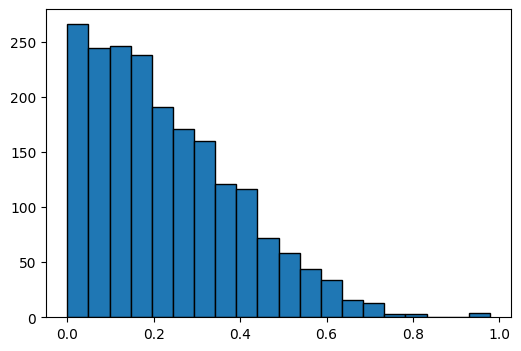

In [67]:
plt.figure(figsize=(6, 4))
plt.hist(list_geobleu_val, bins=20, edgecolor='black')

(array([1.349e+03, 3.940e+02, 1.410e+02, 5.300e+01, 3.000e+01, 1.500e+01,
        5.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.        ,  24.10516898,  48.21033796,  72.31550694,
         96.42067592, 120.5258449 , 144.63101388, 168.73618285,
        192.84135183, 216.94652081, 241.05168979, 265.15685877,
        289.26202775, 313.36719673, 337.47236571, 361.57753469,
        385.68270367, 409.78787265, 433.89304163, 457.9982106 ,
        482.10337958]),
 <BarContainer object of 20 artists>)

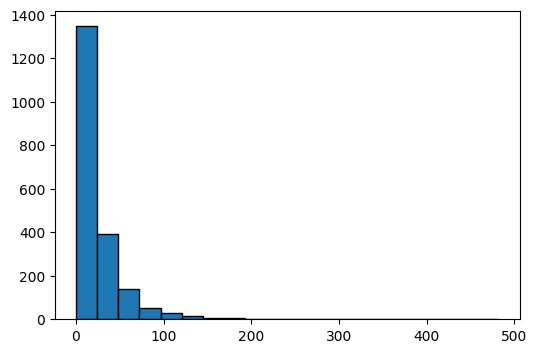

In [68]:
plt.figure(figsize=(6, 4))
plt.hist(list_dtw_val, bins=20, edgecolor='black')

## 可視化して確認

In [69]:
uid = 20308

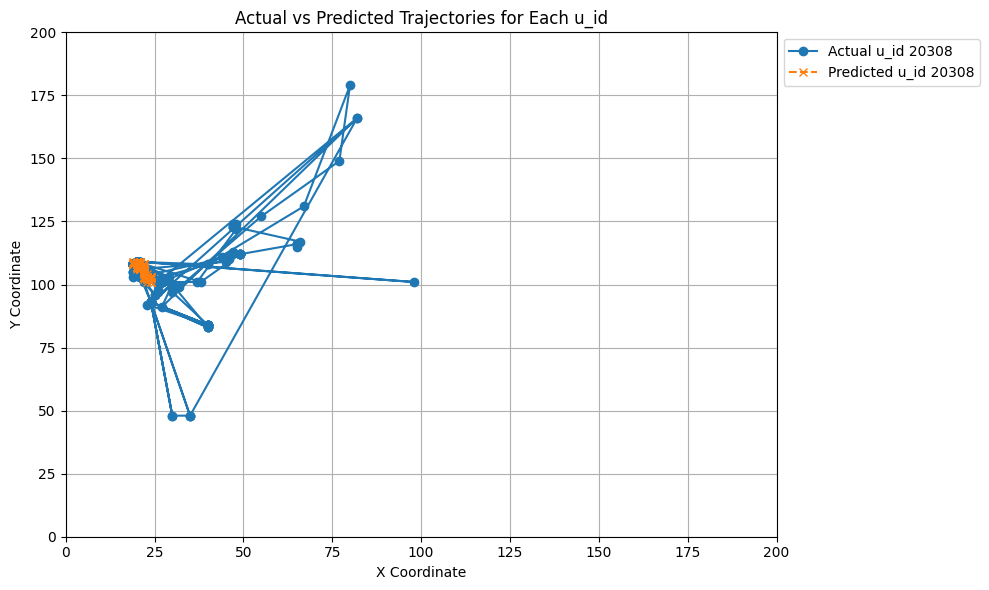

In [70]:
# 特定のuidを見る場合
plt.figure(figsize=(10, 6))

user_data = combined_data[combined_data['uid'] == uid]

# 実際の軌跡をプロット（実線と丸マーカー）
plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}')

# 予測された軌跡をプロット（点線と×マーカー）
plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.xlim(0, 200)  # x軸の範囲を設定
plt.ylim(0, 200)  # y軸の範囲を設定

# プロットを表示
plt.tight_layout()
plt.show()

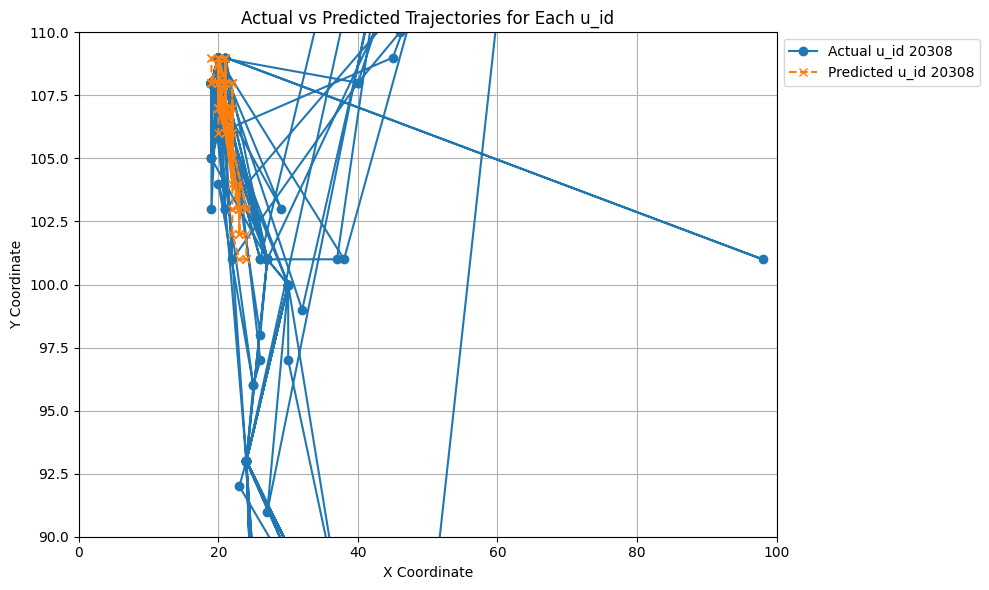

In [71]:
# 特定のuidを見る場合
plt.figure(figsize=(10, 6))

user_data = combined_data[combined_data['uid'] == uid]

# 実際の軌跡をプロット（実線と丸マーカー）
plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}')

# 予測された軌跡をプロット（点線と×マーカー）
plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.xlim(0, 100)  # x軸の範囲を設定
plt.ylim(90, 110)  # y軸の範囲を設定


# プロットを表示
plt.tight_layout()
plt.show()

In [117]:
uid = 21459

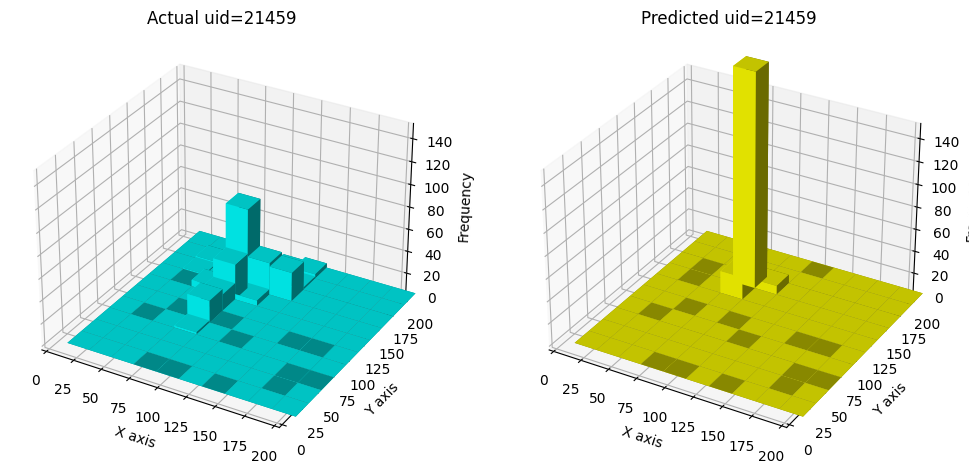

In [119]:
user_data = combined_data[combined_data['uid'] == uid]
# DataFrameからx, yに分割
x1 = user_data['x'].values
y1 = user_data['y'].values
x2 = user_data['x_pred'].values
y2 = user_data['y_pred'].values

# ヒストグラムのビンを設定 (0~200までの範囲に対して適切なビン数)
bins = np.linspace(0, 200, 11)  # 0から200までの範囲で10等分

# 1つ目のデータのヒストグラムを計算
hist1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=[bins, bins])

# 2つ目のデータのヒストグラムを計算
hist2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=[bins, bins])

# 1つ目の座標の中心点を取得
xpos1, ypos1 = np.meshgrid(xedges1[:-1] + 10, yedges1[:-1] + 10, indexing="ij")
xpos1 = xpos1.ravel()
ypos1 = ypos1.ravel()
zpos1 = np.zeros_like(xpos1)

# 2つ目の座標の中心点を取得
xpos2, ypos2 = np.meshgrid(xedges2[:-1] + 10, yedges2[:-1] + 10, indexing="ij")
xpos2 = xpos2.ravel()
ypos2 = ypos2.ravel()
zpos2 = np.zeros_like(xpos2)

# ビンの幅
dx = dy = 20 * np.ones_like(zpos1)

# 3Dヒストグラムをプロット
fig = plt.figure(figsize=(12, 6))  # 図のサイズを指定

# 1つ目のプロット
ax1 = fig.add_subplot(121, projection='3d')  # 1行2列の1つ目
ax1.bar3d(xpos1, ypos1, zpos1, dx, dy, hist1.ravel(), color='cyan', zsort='average')
ax1.set_title(f'Actual uid={uid}')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Frequency')

ax1.set_xlim([0, 200])
ax1.set_ylim([0, 200])
ax1.set_zlim([0, 150])  

################

# 2つ目のプロット
ax2 = fig.add_subplot(122, projection='3d')  # 1行2列の2つ目
ax2.bar3d(xpos2, ypos2, zpos2, dx, dy, hist2.ravel(), color='yellow', zsort='average')
ax2.set_title(f'Predicted uid={uid}')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Frequency')

ax2.set_xlim([0, 200])
ax2.set_ylim([0, 200])
ax2.set_zlim([0, 150])

# プロットを表示
plt.show()

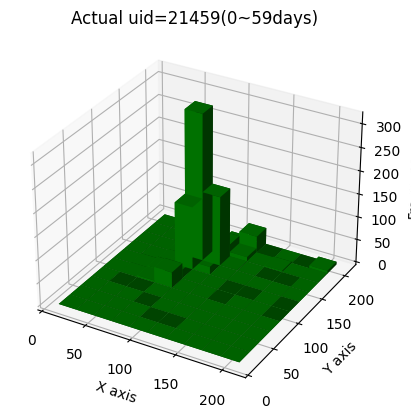

In [123]:
# 0~59日の行動状態も見てみる
user_data = df_city_b_train[df_city_b_train['uid'] == uid]

# DataFrameからx, yに分割
x = user_data['x'].values
y = user_data['y'].values

# ヒストグラムのビンを設定 (0~200までの範囲に対して適切なビン数)
bins = np.linspace(0, 200, 11)  # 0から200までの範囲で10等分

# ヒストグラムを計算
hist, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins])

# 座標の中心点を取得
xpos, ypos = np.meshgrid(xedges[:-1] + 10, yedges[:-1] + 10, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# ビンの幅
dx = dy = 20 * np.ones_like(zpos)
dz = hist.ravel()

# 3Dヒストグラムをプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color='green', zsort='average')
ax.set_title(f'Actual uid={uid}(0~59days)')

# 軸ラベル
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Frequency')

# Show plot
plt.show()
